# Image-Based Plant Disease Detection

We can consider the problem in one of these two modes:

    1. Binary classification: diseased vs. healthy
    2. Multi-class classification: predictiong (crop, disease) pairs, given 38 possible classes. (In this case, to be healthy is a disease itself!)

## Dataset

**PlantVillage:** It is a public dataset, and can be downloaded from https://github.com/spMohanty/PlantVillage-Dataset/tree/master/raw/color
It contains color images of diseased or healthy plant leaves (1GB) collected under controlled conditions. The images classified into 38 labels (54,306 images, 26 diseases, 14 crop species).

## Exploratory Data Analysis

Let's preview two random items:

The label of this leaf is  Potato___Late_blight


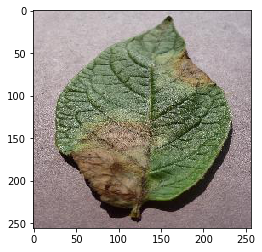

In [0]:
import os
import random
import matplotlib.pyplot as plt

data_dir = os.getcwd()+'/PlantVillage/raw/color/'
random_folder = random.choice(os.listdir(data_dir))
random_leaf = random.choice(os.listdir(data_dir+random_folder))
img = plt.imread(data_dir+ random_folder + '/'+random_leaf)
plt.imshow(img)
print('The label of this leaf is ', random_folder)

In [0]:
img.shape

(256, 256, 3)

The label of this leaf is  Apple___healthy


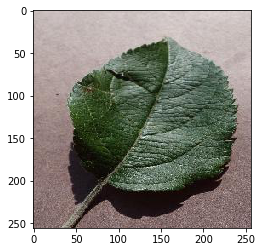

In [0]:
random_folder = random.choice(os.listdir(data_dir))
random_leaf = random.choice(os.listdir(data_dir+random_folder))
img2 = plt.imread(data_dir+ random_folder + '/'+random_leaf)
plt.imshow(img2)
print('The label of this leaf is ', random_folder)

In [0]:
img2.shape

(256, 256, 3)

If we consider the binary classifation problem, it is necessary to know the number of positive (diseased) vs. negative (healthy) cases:

In [0]:
# Find the folders that have the word "healthy", 
# then in each folder, count the number of files
negatives = 0
for f in os.listdir(data_dir):
    if (f.endswith("healthy") and not f.startswith(".")):
        imgs_list = os.listdir(data_dir+'/'+f)
        negatives += len(imgs_list)
print('Number of healthy cases = ', negatives)
positives = 54306-negatives
print('Number of diseased cases = ', positives)

Number of healthy cases =  15084
Number of diseased cases =  39222


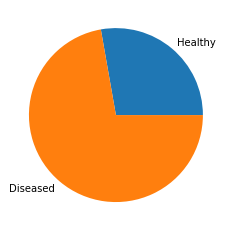

In [0]:
labels = 'Healthy','Diseased'
sizes = [negatives, positives]
plt.pie(sizes,labels=labels)
plt.show()

If we consider the multi-class classifation problem, it is good to know the number of cases in each class:

In [0]:
classes = {}
for f in os.listdir(data_dir):
    num = 0
    if (not f.startswith(".")):
        imgs_list = os.listdir(data_dir+'/'+f)
        num += len(imgs_list)
        classes[f] = num
# for c in classes:
#     print(c,':', classes[c])

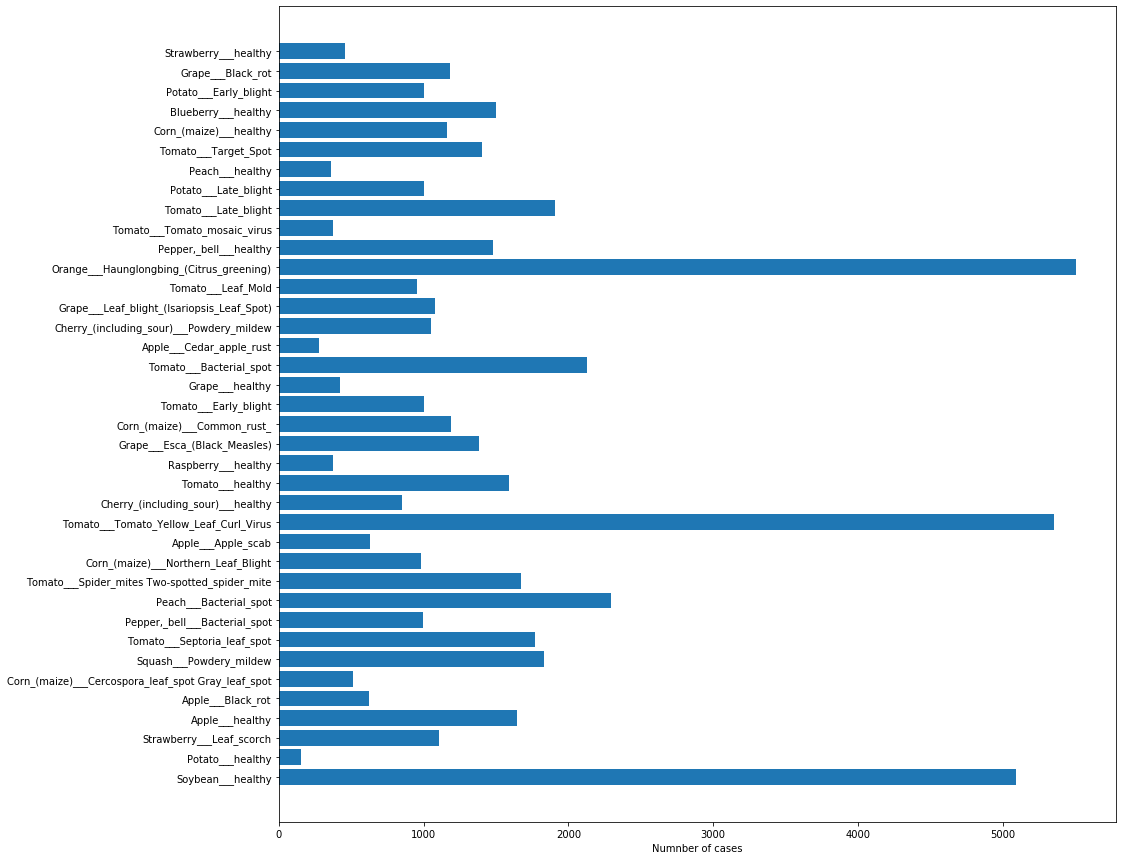

In [0]:
import numpy as np

fig, ax = plt.subplots(figsize=(15,15))
y_pos = np.arange(len(classes.keys()))
ax.barh(y_pos, classes.values())
ax.set_yticks(y_pos)
ax.set_yticklabels(classes.keys())
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Numnber of cases')

plt.show()

Now, we create a dataframe/csv file for images metadata, i.e., file name, label, and binary label for each leaf. Later, this dataframe/file will be used to access the images: 

In [0]:
import pandas as pd

capstone_dir = os.getcwd()+'/'

data_list = []
for label in os.listdir(data_dir):
    if (not label.startswith(".")):
        imgs_list = os.listdir(data_dir + '/' + label)
        imgs_list = [i for i in imgs_list if not i.startswith(".")]
        label_list = [label]*len(imgs_list)
        if label.find('healthy')>=0:
            binary_list = ['0']*len(imgs_list)
        else:
            binary_list = ['1']*len(imgs_list)
        data_list.extend(zip(imgs_list, label_list, binary_list))
df = pd.DataFrame(data_list, columns=['Name','Label', 'Binary'])
# df.to_csv(capstone_dir+'imgs_metadata.csv', index=False)
# df_svm = pd.read_csv(capstone_dir+'imgs_metadata.csv')

In [0]:
df.shape

(54305, 3)

In [0]:
df.head(3)

,Name,Label,Binary
0,8f558908-aa1b-4a86-855a-5094c2392e5a___RS_HL 1...,Strawberry___healthy,0
1,b8e9ed27-8e37-4214-9206-f8c0ef21cf4d___RS_HL 4...,Strawberry___healthy,0
2,abdd34a0-ab02-41e0-95a3-a014ab863ec2___RS_HL 1...,Strawberry___healthy,0


Also, we create a balanced subset of 3000 images (5% of dataset) for binary classification: Diseased (1) vs. Healthy (0). We need this dataframe to train and test our SVM classifier later.

In [0]:
df0 = df[df['Binary']=='0'].sample(n=1500, random_state=99)
df1 = df[df['Binary']=='1'].sample(n=1500, random_state=42)
df_svm = pd.concat([df0,df1])
# df_svm.to_csv(capstone_dir+'imgs_svm_metadata.csv', index=False)
# df_svm = pd.read_csv(capstone_dir+'imgs_svm_metadata.csv')

In [0]:
df_svm.shape

(3000, 3)

## Evaluation Measure

**Precision** = TP/(TP+FP)

**Recall** = TP/(TP+FN)

**F1-score** = 2(Precision*Recall)/(Precision+Recall)

## Base Model

### SVM for binary classification

1. Import necessary libraries

In [0]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from skimage.color import rgb2grey
from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report

2. Create a function to fetch an image: 

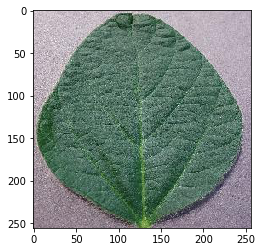

In [0]:
def get_image(img_inf, data_dir = data_dir):
    """
    Extract the image folder and file name from img_inf,
    Read the image,
    Return the image as a numpy array.
    """
    img_folder_name = img_inf['Label']
    img_file_name = img_inf['Name']
    img = Image.open(data_dir + img_folder_name + '/' + img_file_name)
    return np.array(img)

img_row = random.choice(range(3000))
img = get_image(df_svm.iloc[img_row])
plt.imshow(img)

3. We use the histogram of oriented gradients for an image as its input features for our classifier, but first we convert the image to grayscale:

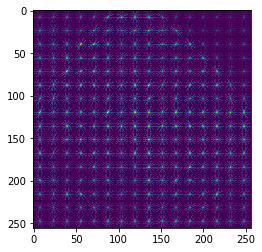

In [0]:
grey_img = rgb2grey(img)
hog_features, hog_image = hog(grey_img, visualize=True, block_norm='L2-Hys', pixels_per_cell=(16, 16))
plt.imshow(hog_image)

So, we write a function to create the matrix of features for all images (dim = number_of_samples * number_of_features).

In [0]:
def create_feature_matrix(imgs_df):
    """
    Input: dataframe of images metadata
    Output: features matrix
    For each image: Get the image file, 
    Covert to grayscale
    """
    features_list = []
    for img_row in range(len(imgs_df)):
        img = get_image(imgs_df.iloc[img_row])
        grey_img = rgb2grey(img)
        hog_features = hog(grey_img, block_norm='L2-Hys', pixels_per_cell=(16, 16))
        features_list.append(hog_features)
    feature_matrix = np.array(features_list)
    return feature_matrix

feature_matrix = create_feature_matrix(df_svm)

In [0]:
feature_matrix.shape

(3000, 15876)

4. Split data for training and testing (60% trainset - 40% testset)

In [0]:
X = pd.DataFrame(feature_matrix)
y = pd.Series(df_svm['Binary'].values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.4,
                                                    random_state=42)

In [0]:
print(pd.Series(y_train).value_counts())

1    918
0    882
dtype: int64


5. Standardize the features matrix

In [0]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

6. Apply PCA for featre reduction

In [0]:
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
print('Number of components after fitting the pca model=', pca.n_components_)

Number of components after fitting the pca model= 970


7. Define SVM classifier

In [0]:
clf = SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

8. Generate predictions

In [0]:
y_pred = clf.predict(X_test)

9. Calculate evaluation measures

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       618
           1       0.66      0.67      0.66       582

    accuracy                           0.67      1200
   macro avg       0.67      0.67      0.67      1200
weighted avg       0.67      0.67      0.67      1200



### Appendix A.
For testing an image on a deployed model (i.e., clf + scaler + pca), we need a function for creating feature vector of the image:

In [0]:
def create_feature_vector_4pred(img_inf, data_dir=data_dir):
    
    img = get_image(img_inf)
    grey_img = rgb2grey(img)
    hog_features = hog(grey_img, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    feature_vector = scaler.transform([hog_features])
    feature_vector = pca.transform(feature_vector)
    return feature_vector 

An example:

In [0]:
one_img = pd.DataFrame([['04ce7b2d-5e41-43c6-9e11-e1bc4f5e4cca___RS_LB 3224.JPG',
                         'Potato___Late_blight', 
                         '1']], columns=['Name','Label', 'Binary'])

X_img = create_feature_vector_4pred(one_img.iloc[0])

y_img_pred = clf.predict(X_img)

if y_img_pred==1:
    print('The classifier detected the leaf as diseased.')
else:
    print('The classifier detected the leaf as healthy.')

The classifier detected the leaf as healthy.


In [0]:
one_img

In [0]:
if one_img.iloc[0]['Binary']==str(y_img_pred):
    print('Correct! Good job!')
else:
    print('Wrong! Bonehead!')

Wrong! Bonehead!
